In [34]:
#Sample data

bids_data_path = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino'
timeseries_path = 'D:/Coursework/NeuroComp2025_TPFinal/Data/TimeSeries'

excluded_subjects_id = ['06', '12', '15', '21', '42', '44']

#atlas = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S2_MNI152NLin6Asym_2mm.nii.gz'
events_file = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/sub-01/func/sub-01_task-mslWithITI_dir-AP_events.tsv'
bold_file = 'D:/Physiology_of_Action_Lab/Prisma_ITI_DePino/derivatives/sub-01/sub-01_task-mslWithITI_dir-AP_desc-smooth_space-IXI549Space_bold.nii.gz'

n_early_blocks_by_task = {
    'mslWithITI': 4,
    'mslWithoutITI': 6
}
n_late_blocks_by_task = {
    'mslWithITI': 24,
    'mslWithoutITI': 22
}

In [24]:
%pip install nilearn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from bids import BIDSLayout


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Auxiliary functions

In [ ]:
def load_events(events_file):
    return pd.read_table(events_file, sep='\t')

def load_timeseries(file):
    return np.genfromtxt(file).transpose()

def add_baseline(events_df):
    new_df = events_df.copy()
    new_df.loc[-1] = [0.0, new_df['onset'].min() , 'baseline', 0]
    new_df.index = new_df.index + 1
    new_df.sort_index(inplace=True) 
    return new_df

def add_amplitude(events_df):
    new_df = events_df.copy()
    new_df['amplitude'] = 1.0
    return new_df

def onsets_to_tr(events_df, tr):
    new_df = events_df.copy()
    new_df['tr_start'] = (new_df['onset'] / tr).round().astype(int)
    
    tr_durations = new_df['tr_start'].shift(-1, fill_value=-1) -  new_df['tr_start'] - 1
    tr_durations.iloc[-1] = (new_df['duration'].iloc[-1] / tr).astype(int) - 1
    new_df['tr_duration'] = tr_durations

    new_df['tr_end'] = new_df['tr_start'] + new_df['tr_duration']
    return new_df

def classify_stage(events_df, n_early_blocks, n_late_blocks, column='block_n'):
    new_df = events_df.copy()
    stage = []
    for index, row in new_df.iterrows():
        block = row[column]
        if block > 0 and block <= n_early_blocks:
            stage.append('early')
        elif block > 0 and block >= (new_df[column].max()-n_late_blocks+1):
            stage.append('late')
        else:
            stage.append(pd.NA)
    new_df['stage'] = stage
    return new_df

def get_blocks(events_df, condition=None, stage=None):
    if condition is not None:
        if stage is not None:
            return events_df[(events_df['trial_type'] == condition) & (events_df['stage'] == stage)]
        else:
            return events_df[events_df['trial_type'] == condition]
    if stage is not None:
        return events_df[events_df['stage'] == stage]
    return events_df

def onsets_to_design(events_df, n_volumes, start_column='tr_start', end_column='tr_end', amplitude_column='amplitude'):
    import numpy as np
    design = np.zeros(n_volumes)
    for index, row in events_df.iterrows():
        start = row[start_column]
        end = row[end_column]
        amplitude = row[amplitude_column]
        design[start:end+1] = amplitude
    return design

'''def convolve(design, tr):
    from nilearn.glm.first_level import spm_hrf
    import numpy as np
    return np.convolve(design, spm_hrf(tr, oversampling=1), mode='full')

def apply_design(signal, design):
    import numpy as np
    signal_applied= []
    for row in signal:
        row_applied = []
        for i in range(min(len(design), len(row))):
            if design[i] != 0:
                row_applied.append(row[i] * design[i])
        signal_applied.append(np.array(row_applied))
    return np.array(signal_applied)

events = load_events(events_file)
events = add_baseline(events)
events = add_amplitude(events)
events = classify_stage(events, 2, 2)
events = onsets_to_tr(events, 0.5)
design = onsets_to_design(get_blocks(events, condition='task', stage='early'), events['tr_end'].max())
conv = convolve(design, 0.5)'''


01


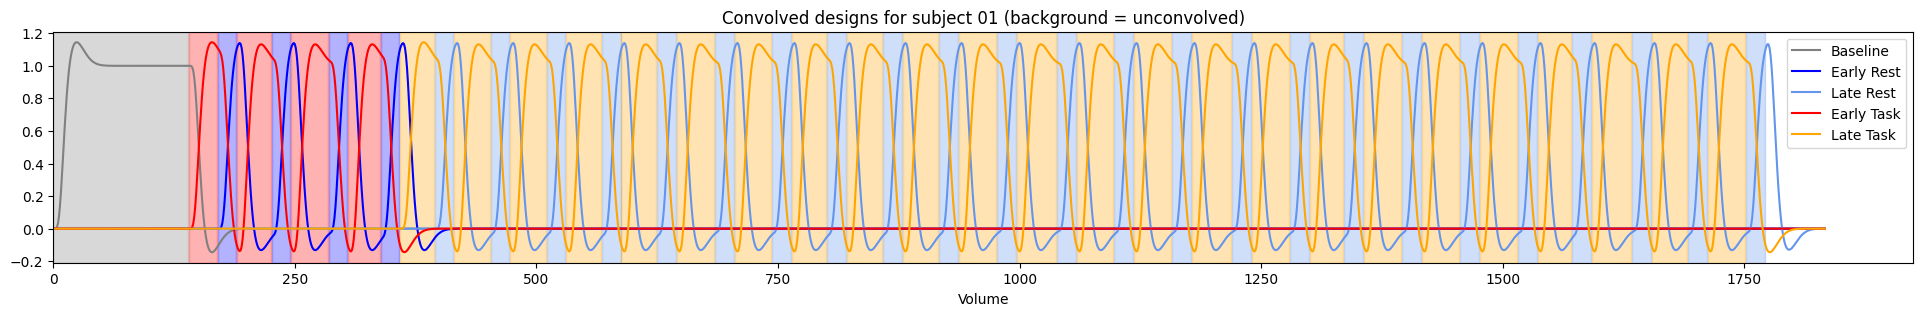

In [125]:
layout = BIDSLayout(bids_data_path, validate=False)

subjects = layout.get_subjects()
tr = layout.get_tr()

timeseries_data = {}

for sub_id in subjects:
    if sub_id in excluded_subjects_id:
        pass
    print(sub_id)
    
    # Get events file
    events_file = layout.get(
        subject = sub_id,
        suffix = 'events',
        extension = '.tsv'
    )[0]
    entities = events_file.entities # For the task id
    events_file = events_file.path # BIDS object to path

    task_id = entities['task']

    # Get timeseries file
    timeseries_file = os.path.join(timeseries_path, f'sub-{sub_id}_task-{task_id}_desc-clean_timeseries.tsv')

    # Load timeseries
    timeseries = load_timeseries(timeseries_file)
    
    # Load onsets and prepare dataframe
    n_early_blocks = n_early_blocks_by_task[task_id]
    n_late_blocks = n_late_blocks_by_task[task_id]
    events = load_events(events_file)
    events = add_baseline(events)
    events = add_amplitude(events)
    events = classify_stage(events, n_early_blocks, n_late_blocks)
    events = onsets_to_tr(events, 0.5)

    # Filter blocks
    events_baseline = get_blocks(events, condition='baseline')
    events_rest_early = get_blocks(events, condition='rest', stage='early')
    events_rest_late = get_blocks(events, condition='rest', stage='late') 
    events_task_early = get_blocks(events, condition='task', stage='early') 
    events_task_late = get_blocks(events, condition='task', stage='late') 

    # Generate designs
    n_volumes = events['tr_end'].max() # max number of volumes estimated from the behavior
    designs = {}
    designs['baseline'] = onsets_to_design(events_baseline, n_volumes)
    designs['rest_early'] = onsets_to_design(events_rest_early, n_volumes)
    designs['rest_late'] = onsets_to_design(events_rest_late, n_volumes)
    designs['task_early'] = onsets_to_design(events_task_early, n_volumes)
    designs['task_late'] = onsets_to_design(events_task_late, n_volumes)
    
    # Convolve designs with SPM's HRF
    convolved_designs = {}
    for des in designs:
        convolved_designs[des] = convolve(designs[des], tr)

    # Plot the designs
    plt.figure(figsize=(24, 3))
    plt.title(f'Convolved designs for subject {sub_id} (background = unconvolved)')
    for i in zip(events_baseline['tr_start'], events_baseline['tr_end']):
        plt.axvspan(i[0], i[1], color='gray', alpha=0.3)
    for i in zip(events_rest_early['tr_start'], events_rest_early['tr_end']):
        plt.axvspan(i[0], i[1], color='blue', alpha=0.3)
    for i in zip(events_rest_late['tr_start'], events_rest_late['tr_end']):
        plt.axvspan(i[0], i[1], color='cornflowerblue', alpha=0.3)
        
    for i in zip(events_task_early['tr_start'], events_task_early['tr_end']):
        plt.axvspan(i[0], i[1], color='red', alpha=0.3)
    for i in zip(events_task_late['tr_start'], events_task_late['tr_end']):
        plt.axvspan(i[0], i[1], color='orange', alpha=0.3)
    plt.plot(convolved_designs['baseline'], label = 'Baseline', color='gray')
    plt.plot(convolved_designs['rest_early'], label = 'Early Rest', color = 'blue')
    plt.plot(convolved_designs['rest_late'], label = 'Late Rest', color = 'cornflowerblue'),
    plt.plot(convolved_designs['task_early'], label = 'Early Task', color = 'red')
    plt.plot(convolved_designs['task_late'], label = 'Late Task', color = 'orange')
    plt.xlim(0)
    plt.xlabel('Volume')
    plt.legend()
    plt.show()

    # Apply the convolved design to the timeseries
    processed_timeseries = {}
    for des in convolved_designs:
        processed_timeseries[des] = apply_design(timeseries, convolved_designs[des])

    # Put the processed timeseries in the master dictionary
    if task_id not in timeseries_data:
        timeseries_data[task_id] = {}
    timeseries_data[task_id][sub_id] = processed_timeseries
    break


baseline 0.9997668343969196


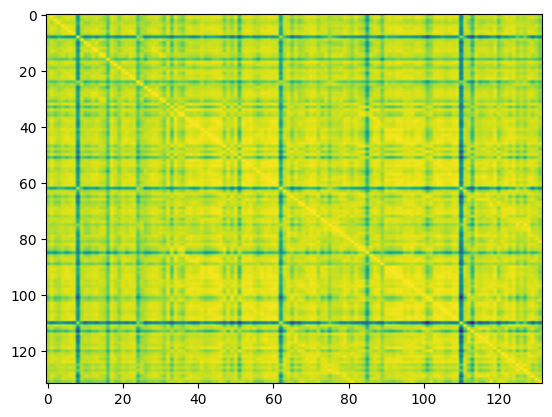

rest_early 0.999958260527939


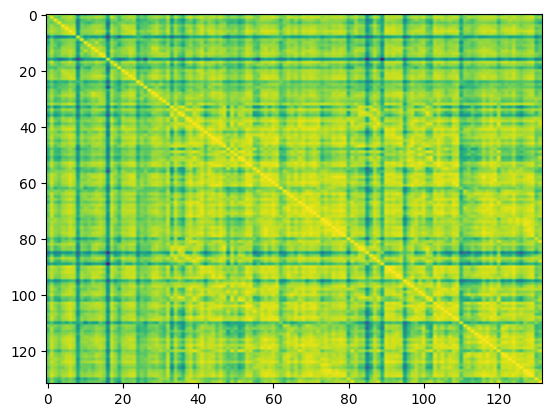

rest_late 0.9999135651758237


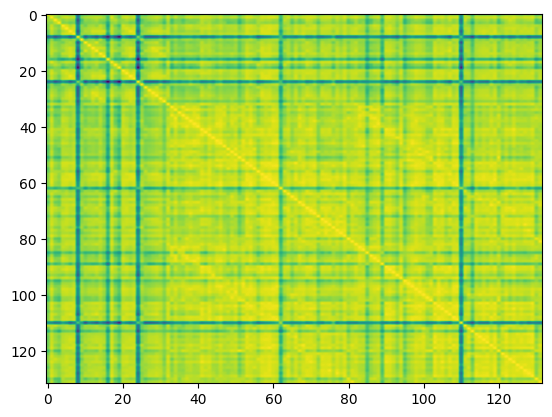

task_early 0.9999417789289118


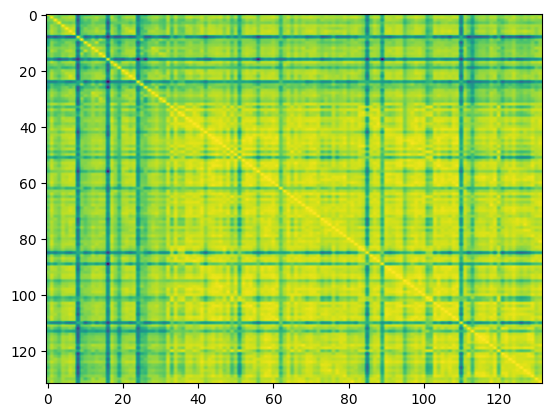

task_late 0.9998327885789461


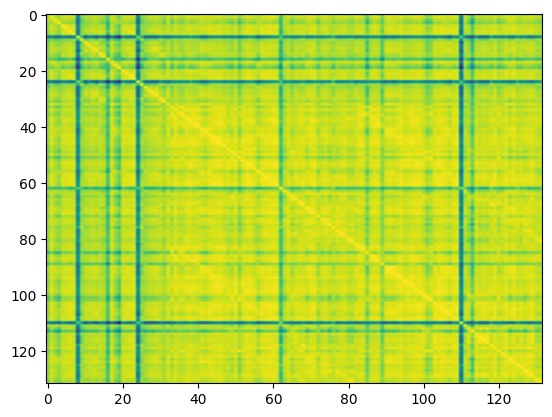

In [135]:
correlation_data = {}
for task_id in timeseries_data:
    correlation_data[task_id] = {}
    for sub_id in timeseries_data[task_id]:
        correlation_data[task_id][sub_id] = {}
        for design in timeseries_data[task_id][sub_id]:
            corr = np.corrcoef(timeseries_data[task_id][sub_id][design])
            #np.fill_diagonal(corr, 0)
            correlation_data[task_id][sub_id][design] = corr
            print(design, corr.min())
            plt.imshow(corr, aspect='auto')
            plt.show()

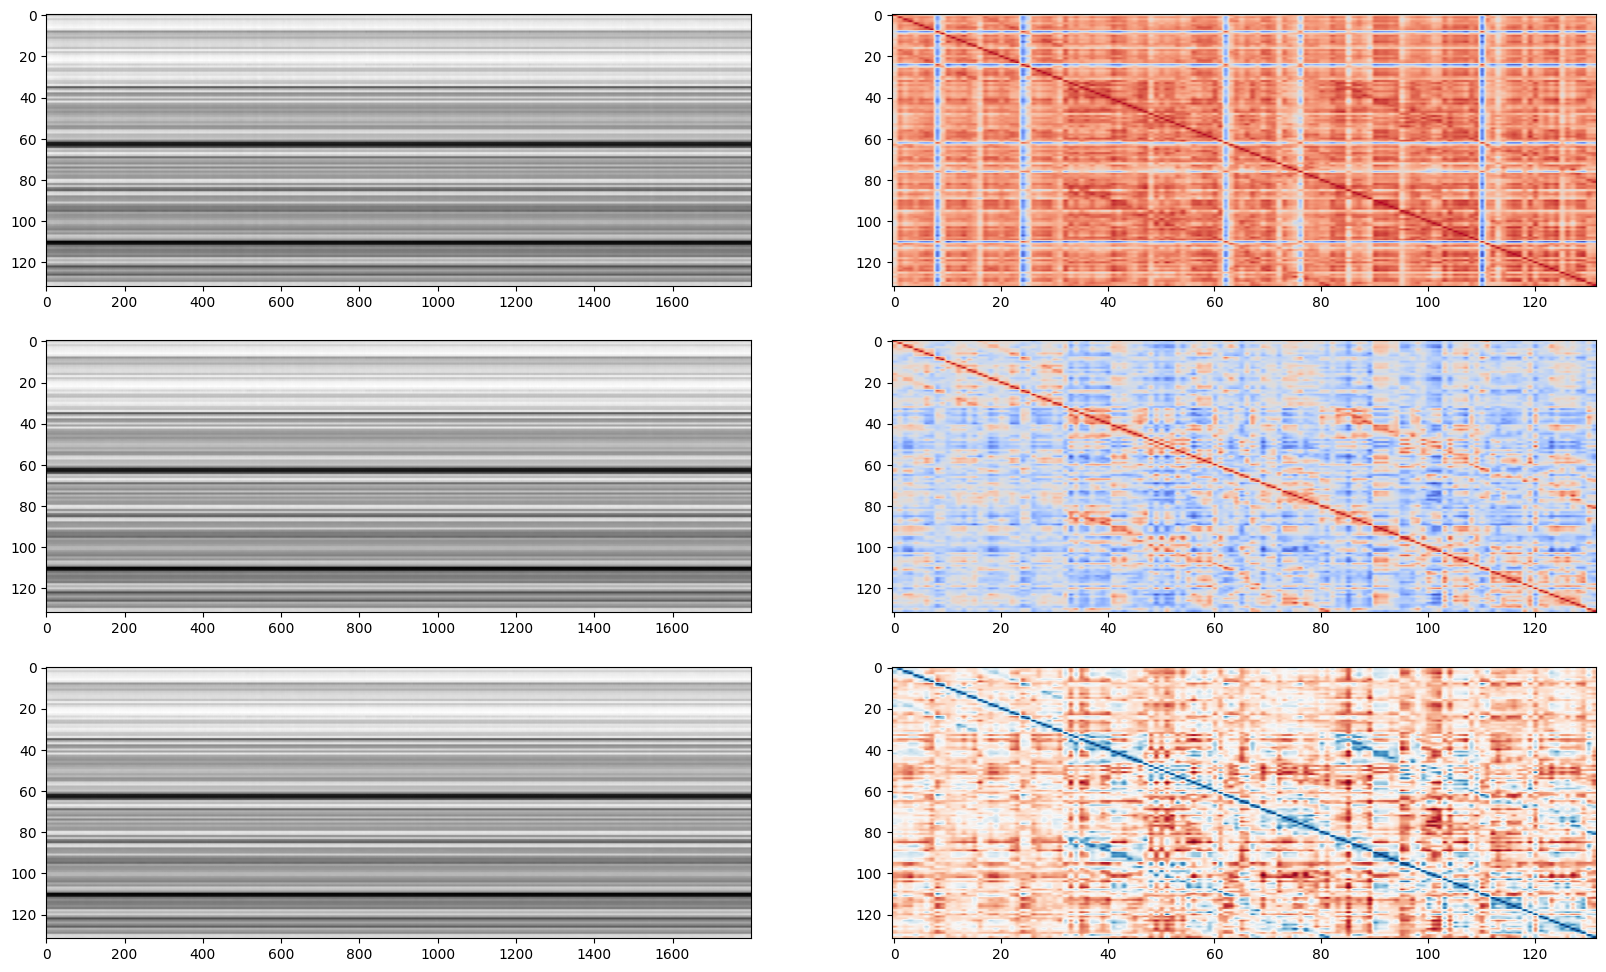

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 12))
plt.subplot(3,2,1)
plt.imshow(np.genfromtxt('time_series_no_confounds'), aspect='auto', cmap='gray')
plt.subplot(3,2,3)
plt.imshow(np.genfromtxt('time_series_with_signal_confounds'), aspect='auto', cmap='gray')
plt.subplot(3,2,5)
plt.imshow(np.genfromtxt('time_series_with_all_confounds'), aspect='auto', cmap='gray')

corr = np.corrcoef(np.genfromtxt('time_series_no_confounds'))
corr_signal = np.corrcoef(np.genfromtxt('time_series_with_signal_confounds'))
corr_all = np.corrcoef(np.genfromtxt('time_series_with_all_confounds'))
plt.subplot(3,2,2)
plt.imshow(corr, aspect='auto', cmap='coolwarm')
plt.subplot(3,2,4)
plt.imshow(corr_signal, aspect='auto', cmap='coolwarm')
plt.subplot(3,2,6)
plt.imshow(corr_all, aspect='auto', cmap='RdBu')


63